In [1]:
import matplotlib.pyplot as plt
import sys
sys.path.insert(0, "/Users/alexabartlett/class/python/build/lib.macosx-10.9-x86_64-3.9")
from classy import Class
import pyccl as ccl
import pyccl.nl_pt as pt
import pyccl.ccllib as lib
import numpy as np
import scipy as sc

plt.rcParams['axes.labelsize']        = 12
plt.rcParams['axes.titlesize']        = 12
plt.rcParams['xtick.labelsize']       = 12
plt.rcParams['ytick.labelsize']       = 12
plt.rcParams['font.family']           = 'serif'
plt.rcParams['font.size']             = 12


The aim of this notebook is to use our tool to forecast the number of N-body simulations required to train HEFT emulator that meets our accuracy requirements for several different use cases.

In [ ]:
zarr = np.linspace(0, 4)

# DESI LRG-EXT
desi_mu = 0.633
desi_std = 0.077
desi_dndz = np.exp(-((zarr-desi_mu)/(desi_std))**2)
desi_shotnoise = 1/(311 * 3282.8) # 2D shot noise
desi_b = 2
DESI_fsky = 0.4

# SO Lensing
SO_noise = np.loadtxt('surveys/nlkk_v3_1_0deproj0_SENS2_fsky0p4_it_lT30-3000_lP30-5000.dat') #noise curve
ell_SO = SO_noise[:,0]
all_SO = SO_noise[:,7]

# Interpolating function for ease of computing variance later
SO_noise_interp = sc.interpolate.interp1d(ell_SO, all_SO)


In [3]:
cosmo = ccl.Cosmology(Omega_c=0.25337, Omega_b=0.04933, h=0.68, sigma8=0.82, n_s=0.96, transfer_function='boltzmann_class')

# ell binning
def get_bins_and_geom_fac(fsky):
    dl = 30
    ellvec = []
    ellval = 30
    ellvec.append(ellval)
    dlvec = []

    while ellval < 3500:
        dl = np.sqrt(900+10*ellval) # As a compromise between log and linear binning
        ellval = (dl + ellval)
        ellvec.append(ellval)
        dlvec.append(dl)
        
    ellvec = np.array(ellvec)
    dlvec = np.array(dlvec)

    ellbins = (ellvec[1:] + ellvec[:-1])*0.5
    geom_fac = np.sqrt(2 / (fsky*dlvec*(2*ellbins + 1)))
    return ellbins, geom_fac

# Using same fsky for DESI and SO
ellbins, geom_fac_DESI = get_bins_and_geom_fac(0.4)
ellbins, geom_fac_LSST = get_bins_and_geom_fac(0.35)


### CMB Lensing with DESI LRG-Ext and SO ###

In [4]:
# Running CCL to get spectra
ell = ellbins

ptt_m = pt.PTMatterTracer()
ptt_g = pt.PTNumberCountsTracer(b1=2.00)

ptc = pt.EulerianPTCalculator(with_NC=True, with_IA=False, log10k_min=-4, log10k_max=2, nk_per_decade=20)

ptc.update_ingredients(cosmo)

pk_gg = ptc.get_biased_pk2d(ptt_g, tracer2=ptt_g)
pk_gm = ptc.get_biased_pk2d(ptt_g, tracer2=ptt_m)
pk_mm = ptc.get_biased_pk2d(ptt_m, tracer2=ptt_m)

t_cmb = ccl.CMBLensingTracer(cosmo, z_source=1088)
t_g = ccl.NumberCountsTracer(cosmo, has_rsd=False, dndz=(zarr, desi_dndz), bias=(zarr, np.ones_like(zarr)), mag_bias=None)

clgg_DESI = ccl.angular_cl(cosmo, t_g, t_g, ell, p_of_k_a=pk_gg)
clkg_cmb = ccl.angular_cl(cosmo, t_g, t_cmb, ell, p_of_k_a=pk_gm)
clkk_cmb = ccl.angular_cl(cosmo, t_cmb, t_cmb, ell, p_of_k_a=pk_mm)


In [5]:
LRG_sn =  1/(311 * 3282.8)
chi_LRG = 0.68*ccl.background.comoving_radial_distance(cosmo, 1/(1+desi_mu))

def k2ell(k):
    return k*chi_LRG - 0.5

def ell2k(ell):
    return (ell+0.5)/chi_LRG


In [6]:
# loading in emulator errors. Indices 0,1,2,3 are 50th, 68th, 95th, and 99th percentile errors
k_emu = np.loadtxt('results/k.txt')
emu_err_SO_tier2 = np.loadtxt('results/SO_lens/tier2_results_ktrunc_kerr_full.txt')
emu_err_SO_tier1 = np.loadtxt('results/SO_lens/tier1_results_ktrunc_kerr_full.txt')
# Training was done over restricted k-range
emu_err_SO_tier1_trunc = np.loadtxt('results/SO_lens/tier1_results_ktrunc_kmaxp6_kerr_full.txt')


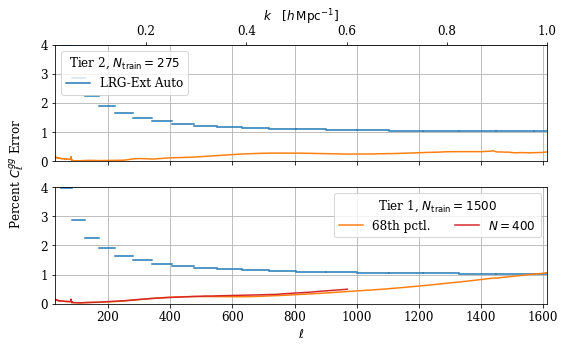

In [7]:
fig, ax = plt.subplots(2, 1, figsize=(8, 5), sharex=True)

delta_ell = np.sqrt(900+10*ell)
clkg_CMB_err = np.sqrt(1+(clkk_cmb+SO_noise_interp(ell))*(clgg_DESI+desi_shotnoise)/(clkg_cmb)**2)

for i in range(len(ellbins)-1):
    if(i==0):
        ax[0].plot([ellbins[i], ellbins[i+1]], [(100*geom_fac_DESI*(1+LRG_sn/clgg_DESI))[i], (100*geom_fac_DESI*(1+LRG_sn/clgg_DESI))[i]], c='C0', label=r'LRG-Ext Auto')
        ax[1].plot([ellbins[i], ellbins[i+1]], [(100*geom_fac_DESI*(1+LRG_sn/clgg_DESI))[i], (100*geom_fac_DESI*(1+LRG_sn/clgg_DESI))[i]], c='C0')

    else:
        ax[0].plot([ellbins[i], ellbins[i+1]], [(100*geom_fac_DESI*(1+LRG_sn/clgg_DESI))[i], (100*geom_fac_DESI*(1+LRG_sn/clgg_DESI))[i]], c='C0')
        ax[1].plot([ellbins[i], ellbins[i+1]], [(100*geom_fac_DESI*(1+LRG_sn/clgg_DESI))[i], (100*geom_fac_DESI*(1+LRG_sn/clgg_DESI))[i]], c='C0')

ax[0].plot((k_emu[:539]*chi_LRG-0.5), 100*emu_err_SO_tier2[1,:], c='C1')
ax[1].plot((k_emu*chi_LRG-0.5)[:539], 100*emu_err_SO_tier1[1,:], c='C1', label='68th pctl.')
ax[1].plot((k_emu*chi_LRG-0.5)[:479], 100*emu_err_SO_tier1_trunc[1,:], c='C3', label='$N=400$')

ax[0].legend(title=r'Tier 2, $N_{\rm train}=275$', loc='upper left', ncol=2)
ax[1].legend(ncol=2, title=r'Tier 1, $N_{\rm train}=1500$')

ax[0].set_ylim(0, 4)
ax[1].set_ylim(0, 4)

ax[0].grid(True)
ax[1].grid(True)

ax[0].set_xlim(30, k2ell(1))
ax[1].set_xlabel(r'$\ell$', fontsize=12)
fig.supylabel('Percent $C_{\ell}^{gg}$ Error', fontsize=12)

secax = ax[0].secondary_xaxis('top', functions=(ell2k, k2ell))
secax.set_xlabel(r'$k\quad[h\,{\rm Mpc}^{-1}]$')


plt.tight_layout()
plt.savefig('figures/CMB_lens_result.pdf')

plt.show()

### DES Y6 GGL with DESI BGS ###

In [8]:
# highest-z bin
z_src_DES, dndz_src_DES = np.loadtxt('surveys/DES_Y6_src_bin_5.csv', unpack=True, usecols=(0, -1), delimiter=',')

bgs_mu = 0.3
bgs_std = 0.2
bgs_b1 = 1.
bgs_shotnoise = 1/(800 * 3282.8) # 2D shot noise, convert from deg^-2 to std^-1
dndz_BGS = np.exp(-((zarr-bgs_mu)/(bgs_std))**2)

neff_DES = 1.6
sigma_eps_DES = 0.29
DES_fsky = 0.1

n_source_per_sterrad = neff_DES * 60**2 * 41253 / (4 * np.pi) # convert from arcmin^-2 to std^-1
shapenoise = sigma_eps_DES**2 / n_source_per_sterrad

In [9]:
# Running CCL for this case
ptt_bgs = pt.PTNumberCountsTracer(b1=bgs_b1) 
t_bgs = ccl.NumberCountsTracer(cosmo, has_rsd=False, dndz=(zarr, dndz_BGS), bias=(zarr, np.ones_like(zarr)), mag_bias=None)
t_source = ccl.WeakLensingTracer(cosmo, dndz=(z_src_DES, dndz_src_DES))

pk_gg_bgs = ptc.get_biased_pk2d(ptt_g, tracer2=ptt_g)
pk_gm_bgs = ptc.get_biased_pk2d(ptt_g, tracer2=ptt_m)

clgg_bgs = ccl.angular_cl(cosmo, t_bgs, t_bgs, ell, p_of_k_a=pk_gg_bgs)
clkg_gal = ccl.angular_cl(cosmo, t_bgs, t_source, ell, p_of_k_a=pk_gm_bgs)
clkk_gal = ccl.angular_cl(cosmo, t_source, t_source, ell, p_of_k_a=pk_mm)

In [10]:
# calculating error in cross spectrum (without geometric factors)
clkg_gal_err = np.sqrt(1+(clkk_gal+shapenoise)*(clgg_bgs+bgs_shotnoise)/(clkg_gal)**2)

In [11]:
chi_bgs = 0.68*ccl.background.comoving_radial_distance(cosmo, 1/(1+bgs_mu))

def k2ell_bgs(k):
    return k*chi_bgs - 0.5

def ell2k_bgs(ell):
    return (ell+0.5)/chi_bgs


In [12]:
geom_fac_DES = get_bins_and_geom_fac(DES_fsky)[1]
emu_err_DES_tier2 = np.loadtxt('results/DES_GGL/tier2_results_ktrunc_kerr_full.txt')
emu_err_DES_tier1 = np.loadtxt('results/DES_GGL/tier1_results_ktrunc_kerr_full.txt')


/var/folders/bl/xyxyl0d10p91mlywms1l_wph0000gn/T/ipykernel_74656/1700782483.py:34: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


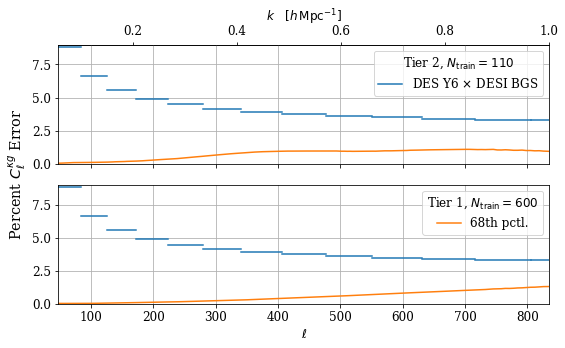

In [13]:
fig, ax = plt.subplots(2, 1, figsize=(8,5), sharex=True)

for i in range(len(ellbins)-1):
    if i==0:
        ax[0].plot([ellbins[i], ellbins[i+1]], [(100*geom_fac_DES*clkg_gal_err)[i]/np.sqrt(2), (100*geom_fac_DES*clkg_gal_err)[i]/np.sqrt(2)], c='C0', label=r'DES Y6 $\times$ DESI BGS')
        ax[1].plot([ellbins[i], ellbins[i+1]], [(100*geom_fac_DES*clkg_gal_err)[i]/np.sqrt(2), (100*geom_fac_DES*clkg_gal_err)[i]/np.sqrt(2)], c='C0')

    else:
        ax[0].plot([ellbins[i], ellbins[i+1]], [(100*geom_fac_DES*clkg_gal_err)[i]/np.sqrt(2), (100*geom_fac_DES*clkg_gal_err)[i]/np.sqrt(2)], c='C0')
        ax[1].plot([ellbins[i], ellbins[i+1]], [(100*geom_fac_DES*clkg_gal_err)[i]/np.sqrt(2), (100*geom_fac_DES*clkg_gal_err)[i]/np.sqrt(2)], c='C0')
    

ax[0].plot(k_emu[:539]*chi_bgs-0.5, 100*emu_err_DES_tier2[1,:], c='C1')
ax[1].plot(k_emu[:539]*chi_bgs-0.5, 100*emu_err_DES_tier1[1,:], c='C1', label='68th pctl.')

ax[0].legend(ncol=2, title=r'Tier 2, $N_{\rm train}=110$')
ax[1].legend(ncol=2, title=r'Tier 1, $N_{\rm train}=600$')

secax = ax[0].secondary_xaxis('top', functions=(ell2k_bgs, k2ell_bgs))
secax.set_xlabel(r'$k\quad[h\,{\rm Mpc}^{-1}]$')

ax[0].set_xlim(min(ell), k2ell_bgs(1))
ax[0].set_ylim(0, 9)
ax[0].grid(True)
ax[1].set_xlim(min(ell), k2ell_bgs(1))
ax[1].set_ylim(0, 9)
ax[1].grid(True)

ax[1].set_xlabel(r'$\ell$', fontsize=12)
fig.supylabel('Percent $C_{\ell}^{\kappa g}$ Error')
fig.tight_layout()

fig.savefig('figures/DES_Y3_BGS_GGL.pdf')
fig.show()

### RST Shear ###

In [14]:
z_wl, nz_wl = np.loadtxt('surveys/roman_highz_src.csv', unpack=True, delimiter=',')

neff_RST_med = 41.3/10 # arcmin^-2
sigep_RST = 0.26
fsky_RST_med = 0.06

neff_RST_wide = 12.7/10 # arcmin^-2
fsky_RST_wide = 0.06

# convert to std^-1
n_source_per_std_med = neff_RST_med * 60**2 * 41253 / (4 * np.pi)
n_source_per_std_wide = neff_RST_wide * 60**2 * 41253 / (4 * np.pi)

sn_RST_med = sigep_RST**2 / n_source_per_std_med
sn_RST_wide = sigep_RST**2 / n_source_per_std_wide

t_source = ccl.WeakLensingTracer(cosmo, dndz=(z_wl, nz_wl))
t_g = ccl.NumberCountsTracer(cosmo, has_rsd=False, dndz=(zarr, desi_dndz), bias=(zarr, np.ones_like(zarr)), mag_bias=None)

clkk_rst = ccl.angular_cl(cosmo, t_source, t_source, ell, p_of_k_a=pk_mm)
clkg_rst = ccl.angular_cl(cosmo, t_g, t_source, ell, p_of_k_a=pk_mm)
clkk_rst_err_med = 1 + sn_RST_med/clkk_rst
clkk_rst_err_wide = 1 + sn_RST_wide/clkk_rst

geom_fac_RST_med = get_bins_and_geom_fac(fsky_RST_med)[1]
geom_fac_RST_wide =  get_bins_and_geom_fac(fsky_RST_wide)[1]

clkk_rst_err_comb = 1/((1/(geom_fac_RST_med*clkk_rst_err_med))+(1/(geom_fac_RST_wide*clkk_rst_err_wide)))


In [15]:
# About half way to z=1.65
chi_rst = 0.68*ccl.background.comoving_radial_distance(cosmo, 1/(1+0.635))

def k2ell_rst(k):
    return k*chi_rst - 0.5

def ell2k_rst(ell):
    return (ell+0.5)/chi_rst


In [16]:
emu_err_RST_tier1 = np.loadtxt('results/RST_Shear/tier1_results_ktrunc_kerr_full.txt')
emu_err_RST_tier2 = np.loadtxt('results/RST_Shear/tier2_results_ktrunc_kerr_full.txt')

emu_err_RST_tier1_trunc = np.loadtxt('results/RST_Shear/tier1_results_kmaxp7_kerr_full.txt')


/var/folders/bl/xyxyl0d10p91mlywms1l_wph0000gn/T/ipykernel_74656/1446792663.py:32: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


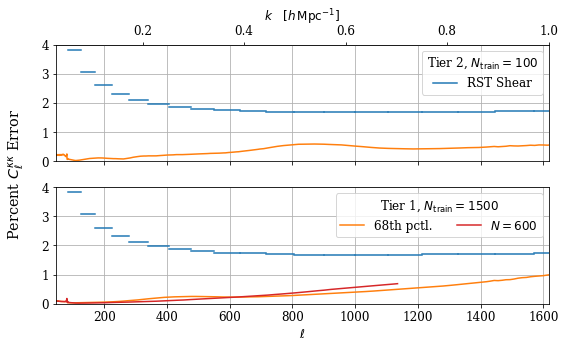

In [17]:
fig, ax = plt.subplots(2, 1, figsize=(8,5), sharex=True)

for i in range(len(ellbins)-1):
    ax[0].plot([ellbins[i], ellbins[i+1]], [(100*clkk_rst_err_comb)[i], (100*clkk_rst_err_comb)[i]], c='C0')
    ax[1].plot([ellbins[i], ellbins[i+1]], [(100*clkk_rst_err_comb)[i], (100*clkk_rst_err_comb)[i]], c='C0')


ax[0].plot(k_emu*chi_rst-0.5, 100*emu_err_RST_tier2[1,:], c='C1', label='68th pctl.')

ax[1].plot(k_emu*chi_rst-0.5, 100*emu_err_RST_tier1[1,:], c='C1', label='68th pctl.')
ax[1].plot(k_emu[:497]*chi_rst-0.5, 100*emu_err_RST_tier1_trunc[1,:], c='C3', label='$N=600$')

secax = ax[0].secondary_xaxis('top', functions=(ell2k_rst, k2ell_rst))
secax.set_xlabel(r'$k\quad[h\,{\rm Mpc}^{-1}]$')

ax[0].set_xlim(min(ell), k2ell_rst(1))
ax[0].set_ylim(0,4)
ax[0].grid(True)
ax[0].set_xlim(min(ell), k2ell_rst(1))
ax[1].set_ylim(0,4)
ax[1].grid(True)

ax[1].set_xlabel(r'$\ell$')
fig.supylabel('Percent $C_{\ell}^{\kappa \kappa}$ Error')
fig.tight_layout()

ax[0].legend(['RST Shear'], ncol=2, title=r'Tier 2, $N_{\rm train}=100$')
ax[1].legend(ncol=2, title=r'Tier 1, $N_{\rm train}=1500$')
fig.tight_layout()

fig.savefig('figures/RST_shear_err.pdf')
fig.show()


### Steel Sample ###

In [18]:
src_LSST = np.loadtxt('surveys/nz_lsst_5sbins.txt', unpack=True)
z_src_steel = src_LSST[0]
dndz_src_steel = src_LSST[-2]
dndz_src_steel2 = src_LSST[-3]
dndz_lens_steel = src_LSST[1]
neff_steel = 4/4 #arcmin^{-2} # per bin

n_source_per_sterrad_steel = neff_steel * 60**2 * 41253 / (4 * np.pi)
steel_shotnoise = 1/n_source_per_sterrad_steel
sigma_eps_steel = 0.26

steel_fsky = 0.35

shapenoise_steel = sigma_eps_steel**2 / n_source_per_sterrad_steel


In [19]:
steel_mu = 0.35
chi_steel = 0.68*ccl.background.comoving_radial_distance(cosmo, 1/(1+steel_mu))

def k2ell_steel(k):
    return k*chi_steel - 0.5

def ell2k_steel(ell):
    return (ell+0.5)/chi_steel


In [20]:
ptt_steel = pt.PTNumberCountsTracer(b1=1) 
pk_gg_steel = ptc.get_biased_pk2d(ptt_steel, tracer2=ptt_steel)
pk_gm_steel = ptc.get_biased_pk2d(ptt_steel, tracer2=ptt_m)

In [21]:
t_source_hiz_steel = ccl.WeakLensingTracer(cosmo, dndz=(z_src_steel, dndz_src_steel))
t_source_midz_steel = ccl.WeakLensingTracer(cosmo, dndz=(z_src_steel, dndz_src_steel2))

t_lens_steel = ccl.NumberCountsTracer(cosmo, has_rsd=False, dndz=(z_src_steel, dndz_lens_steel), bias=(zarr, np.ones_like(zarr)), mag_bias=None)

clkk_steel_auto = ccl.angular_cl(cosmo, t_source_hiz_steel, t_source_hiz_steel, ell, p_of_k_a=pk_mm)
clkk_steel_cross = ccl.angular_cl(cosmo, t_source_hiz_steel, t_source_midz_steel, ell, p_of_k_a=pk_mm)

clkg_steel = ccl.angular_cl(cosmo, t_lens_steel, t_source_hiz_steel, ell, p_of_k_a=pk_gm_steel)
clgg_steel = ccl.angular_cl(cosmo, t_lens_steel, t_lens_steel, ell, p_of_k_a=pk_gm_steel)

geom_fac_steel =  get_bins_and_geom_fac(steel_fsky)[1]
steel_shear_err_auto = 1 + shapenoise_steel/clkk_steel_auto
steel_shear_err_cross = 1 + shapenoise_steel/clkk_steel_cross
steel_gg_err = 1 + steel_shotnoise/clgg_steel


In [22]:
clkg_steel_err = np.sqrt(1+(clkk_steel_auto+shapenoise_steel)*(clgg_steel+steel_shotnoise)/(clkg_steel)**2)

In [23]:
tier2_err_steel = np.loadtxt('results/Steel_GGL/tier2_results_ktrunc_kerr_full.txt')
tier1_err_steel = np.loadtxt('results/Steel_GGL/tier1_results_ktrunc_kerr_full.txt')

/var/folders/bl/xyxyl0d10p91mlywms1l_wph0000gn/T/ipykernel_74656/1917973473.py:30: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


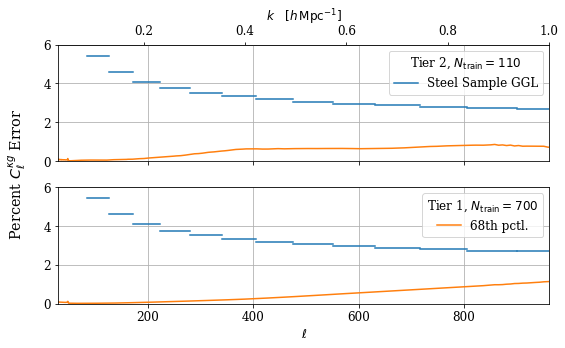

In [24]:
fig, ax = plt.subplots(2, 1, figsize=(8,5), sharex=True)

for i in range(len(ellbins)-1):

    ax[0].plot([ellbins[i], ellbins[i+1]], [(100*geom_fac_steel*clkg_steel_err)[i], (100*geom_fac_steel*clkg_steel_err)[i]], c='C0')
    ax[1].plot([ellbins[i], ellbins[i+1]], [(100*geom_fac_steel*clkg_steel_err)[i], (100*geom_fac_steel*clkg_steel_err)[i]], c='C0')

secax = ax[0].secondary_xaxis('top', functions=(ell2k_steel, k2ell_steel))
secax.set_xlabel(r'$k\quad[h\,{\rm Mpc}^{-1}]$')

ax[0].plot(k_emu[:539]*chi_steel-0.5, 100*tier2_err_steel[1,:], c='C1', label='68th pctl.')
ax[1].plot(k_emu[:539]*chi_steel-0.5, 100*tier1_err_steel[1,:], c='C1', label='68th pctl.')

ax[0].set_xlim(30,k2ell_steel(1))
ax[0].set_ylim(0, 6)
ax[0].grid()

ax[1].set_xlim(30,k2ell_steel(1))
ax[1].set_ylim(0, 6)
ax[1].set_xlabel(r'$\ell$', fontsize=12)
ax[1].grid()

ax[0].legend(['Steel Sample GGL'], ncol=2, title=r'Tier 2, $N_{\rm train}=110$')
ax[1].legend(ncol=2, title=r'Tier 1, $N_{\rm train}=700$')

fig.supylabel('Percent $C_{\ell}^{\kappa g}$ Error')
fig.tight_layout()

fig.savefig('figures/Steel_GGL.pdf')
fig.show()